This notebook aims to build abaseline model on the Breast Cancer IDC histopathology images.

In [1]:
%matplotlib inline 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib as plt
import matplotlib.pyplot as pyplt
import matplotlib.image as mpimg
from skimage import io

In [3]:
import wget
import time
import os
import copy

In [4]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [5]:
import fastai
from fastai.vision.image import *
from fastai.vision import *
from fastai.metrics import *

In [6]:
fastai.__version__

'1.0.60'

In [7]:
data_root = "/home/ubuntu/datasets/breast-histopathology-images/"

In [8]:
!ls -l $data_root | head -5

total 3283148
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10253
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10254
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10255
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:51 10256
ls: write error: Broken pipe


In [9]:
!ls -l $data_root | tail -5

drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:52 9382
drwxr-xr-x   4 ubuntu ubuntu       4096 Feb  2 17:52 9383
-rw-rw-r--   1 ubuntu ubuntu 3326820824 Jan 31 15:54 breast-histopathology-images.zip
drwxr-xr-x 281 ubuntu ubuntu      12288 Feb  2 17:52 IDC_regular_ps50_idx5
-rw-r--r--   1 ubuntu ubuntu   33957737 Feb 18 22:06 train_labels.csv


In [10]:
!ls -l $data_root | wc -l

283


Seems we have the data of 279 patients. (subtracting the 3 irrelevant entries)

In [11]:
from glob import glob
import fnmatch

In [12]:
# glob is a very useful library when training data is distributed across multiple directories
image_patches = glob('/home/ubuntu/datasets/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
len(image_patches), image_patches[:5]

(277524,
 ['/home/ubuntu/datasets/breast-histopathology-images/IDC_regular_ps50_idx5/10273/1/10273_idx5_x2051_y1451_class1.png',
  '/home/ubuntu/datasets/breast-histopathology-images/IDC_regular_ps50_idx5/10273/1/10273_idx5_x2751_y1401_class1.png',
  '/home/ubuntu/datasets/breast-histopathology-images/IDC_regular_ps50_idx5/10273/1/10273_idx5_x1251_y1701_class1.png',
  '/home/ubuntu/datasets/breast-histopathology-images/IDC_regular_ps50_idx5/10273/1/10273_idx5_x2351_y1001_class1.png',
  '/home/ubuntu/datasets/breast-histopathology-images/IDC_regular_ps50_idx5/10273/1/10273_idx5_x1951_y1001_class1.png'])

In [13]:
tt = pd.DataFrame(image_patches)
tt.head(4)

,0
0,/home/ubuntu/datasets/breast-histopathology-im...
1,/home/ubuntu/datasets/breast-histopathology-im...
2,/home/ubuntu/datasets/breast-histopathology-im...
3,/home/ubuntu/datasets/breast-histopathology-im...


In [14]:
tt2 = tt[0].str.split("/").to_list()
names = ["1", "2", "3", "4", "5", "6", "patient_id", "target", "image"]
train_df = pd.DataFrame(tt2, columns=names)
train_df.drop(['1', '2', '3', '4', '5', '6'], axis=1, inplace=True)
train_df['path'] = tt[0]

train_df.iloc[:5,:]

,patient_id,target,image,path
0,10273,1,10273_idx5_x2051_y1451_class1.png,/home/ubuntu/datasets/breast-histopathology-im...
1,10273,1,10273_idx5_x2751_y1401_class1.png,/home/ubuntu/datasets/breast-histopathology-im...
2,10273,1,10273_idx5_x1251_y1701_class1.png,/home/ubuntu/datasets/breast-histopathology-im...
3,10273,1,10273_idx5_x2351_y1001_class1.png,/home/ubuntu/datasets/breast-histopathology-im...
4,10273,1,10273_idx5_x1951_y1001_class1.png,/home/ubuntu/datasets/breast-histopathology-im...


In [15]:
img_coords = [img.split('_',4)[2:4] for img in train_df['image']]
train_df['x_coords'] = [int(coords[0][1:]) for coords in img_coords]
train_df['y_coords'] = [int(coords[1][1:]) for coords in img_coords]

train_df.iloc[:5,:]

,patient_id,target,image,path,x_coords,y_coords
0,10273,1,10273_idx5_x2051_y1451_class1.png,/home/ubuntu/datasets/breast-histopathology-im...,2051,1451
1,10273,1,10273_idx5_x2751_y1401_class1.png,/home/ubuntu/datasets/breast-histopathology-im...,2751,1401
2,10273,1,10273_idx5_x1251_y1701_class1.png,/home/ubuntu/datasets/breast-histopathology-im...,1251,1701
3,10273,1,10273_idx5_x2351_y1001_class1.png,/home/ubuntu/datasets/breast-histopathology-im...,2351,1001
4,10273,1,10273_idx5_x1951_y1001_class1.png,/home/ubuntu/datasets/breast-histopathology-im...,1951,1001


In [16]:
train_labels = train_df[['path','target']]
train_labels.to_csv('/home/ubuntu/datasets/breast-histopathology-images/train_labels.csv')

### Create the databunch

This section extensively uses code from Amerii's kernel from here: https://www.kaggle.com/amerii/breast-cancer-classification-end-to-end

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [18]:
additional_aug=[*zoom_crop(scale=(0.95,1.05), do_rand=False), 
#                     brightness(scale=(0.4, 0.6)), 
#                     contrast(scale=(0.6, 1.4), p=0.75)
                   ]
tfms = get_transforms(dihedral_affine(),max_lighting=0.2, max_zoom=1.15, xtra_tfms=additional_aug)

In [19]:
fnames=get_files(data_root, recurse=True)
fnames[:5], fnames[-5:]

([PosixPath('/home/ubuntu/datasets/breast-histopathology-images/train_labels.csv'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/breast-histopathology-images.zip'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x2051_y1451_class1.png'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x2751_y1401_class1.png'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x1251_y1701_class1.png')],
 [PosixPath('/home/ubuntu/datasets/breast-histopathology-images/9036/0/9036_idx5_x1801_y451_class0.png'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/9036/0/9036_idx5_x2051_y2051_class0.png'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/9036/0/9036_idx5_x951_y2451_class0.png'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-images/9036/0/9036_idx5_x1051_y2001_class0.png'),
  PosixPath('/home/ubuntu/datasets/breast-histopathology-image

In [20]:
type(fnames)

list

In [21]:
fnames.pop(0)
fnames.pop(0)
fnames[:5]

[PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x2051_y1451_class1.png'),
 PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x2751_y1401_class1.png'),
 PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x1251_y1701_class1.png'),
 PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x2351_y1001_class1.png'),
 PosixPath('/home/ubuntu/datasets/breast-histopathology-images/10273/1/10273_idx5_x1951_y1001_class1.png')]

In [22]:
pattern= r'([^/_]+).png'
data = ImageDataBunch.from_name_re(data_root, fnames, pattern, ds_tfms=tfms, size=50, bs=256,num_workers=2
                                  ).normalize()

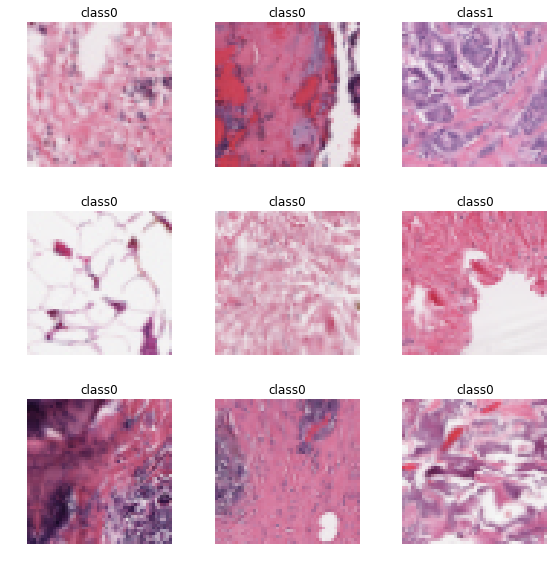

In [23]:
data.show_batch(rows=3, figsize=(8,8))

In [24]:
arch = models.resnet34
learn= cnn_learner(data, arch, metrics=[accuracy, error_rate], model_dir='/home/ubuntu/outputs/working/')

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


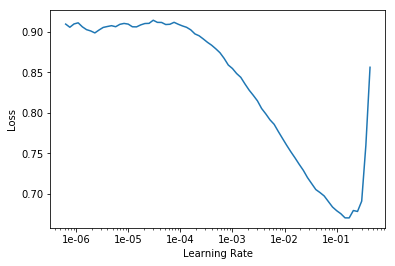

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
lr=1e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.298704,0.311037,0.863930,0.136070,04:29
1,0.291462,0.321583,0.864200,0.135800,04:34
2,0.278421,0.298016,0.872749,0.127251,04:30
3,0.261412,0.308786,0.870110,0.129890,04:28
4,0.260967,0.281058,0.881154,0.118846,04:31


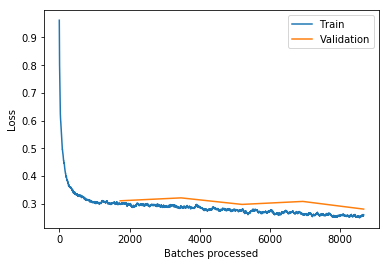

In [27]:
learn.recorder.plot_losses()

In [28]:
learn.save('BC-IDC-histopathology-stage-1-resnet34')

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


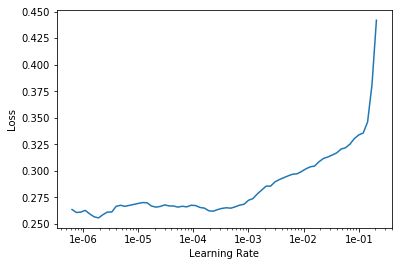

In [29]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(6,slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.257050,0.276276,0.882478,0.117522,04:30
1,0.256331,0.279050,0.882280,0.117720,04:29
2,0.248662,0.280064,0.882136,0.117864,04:27
3,0.255731,0.266875,0.887099,0.112901,04:28
4,0.253477,0.275716,0.883460,0.116540,04:31
5,0.248062,0.275226,0.883298,0.116702,04:30


In [31]:
learn.save('BC-IDC-histopathology-stage-2-resnet34')

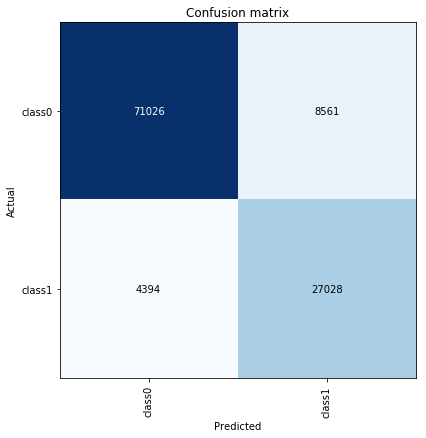

In [32]:
interp= ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))